<a href="https://colab.research.google.com/github/ngrvineeth/Convolution-Neural-Netwotk-Model-VGG16-for-Detection-of-COVID-19-from-Chest-X-Ray-Images/blob/main/COVID_19_Detection(CNN_VGG16%20model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path='/content/drive/My Drive/deep learning projects/covid19/keras-covid-19/Dataset'
print(dataset_path)

/content/drive/My Drive/deep learning projects/covid19/keras-covid-19/Dataset


In [4]:
sys.path.append('/content/drive/My Drive/deep learning projects/covid19/keras-covid-19')
import city_coders
from city_coders import *

data,labels=load_rgb_data_cv(dataset_path,244,shuffle=True)
print(data.shape)
print(labels.shape)

Loading images...
Loading Covid
we will load [ 196 ] files from [ Covid ] class ...
Loading Normal
we will load [ 196 ] files from [ Normal ] class ...
File loading completed.
(392, 244, 244, 3)
(392,)


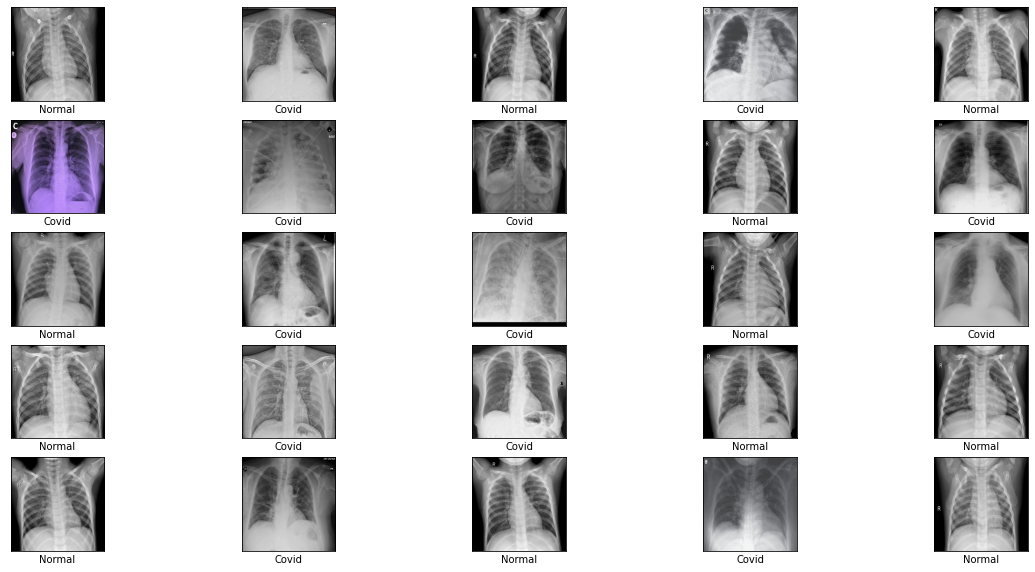

In [5]:
city_coders.plot_sample_from_dataset(data,labels,rows=5,colums=5,width=20,height=10)

Label = Covid
image shape:  (244, 244, 3)


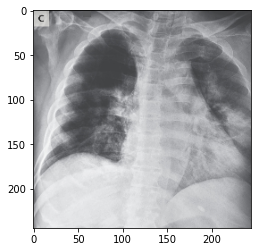

In [6]:
city_coders.display_image(data,labels,index=3)

In [7]:
city_coders.display_dataset_folders(dataset_path)

['Covid', 'Normal']


In [8]:
data,labels=city_coders.load_rgb_data(dataset_path,244,shuffle=True)
data=city_coders.normalize_data(data)

#perform one-hot encoding on the labels
print("labels :",labels[:5])
lb=LabelBinarizer()
binary_labels=lb.fit_transform(labels)
print("binary_labels after Binarizer :",binary_labels[:5])
hot_encoded_labels=to_categorical(binary_labels)
print("hot_encoded_labels after one-hot encoding :",hot_encoded_labels[:5])

Loading images...
['Covid', 'Normal']
Loading Covid
we will load [ 196 ] files from [ Covid ] class ...
Loading Normal
we will load [ 196 ] files from [ Normal ] class ...
File loading completed.
normalize data
labels : ['Covid' 'Covid' 'Covid' 'Covid' 'Covid']
binary_labels after Binarizer : [[0]
 [0]
 [0]
 [0]
 [0]]
hot_encoded_labels after one-hot encoding : [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


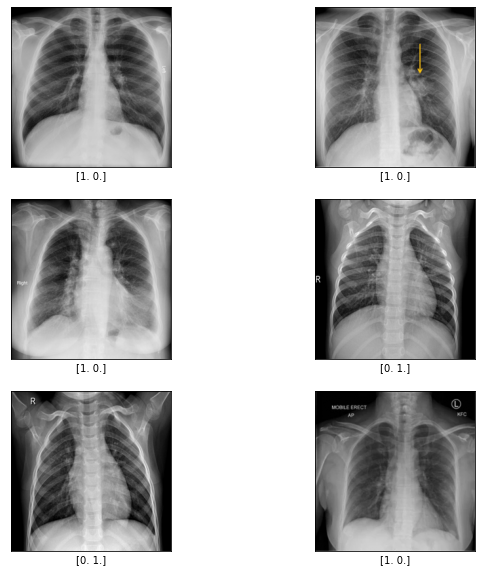

Shape of images:  (313, 244, 244, 3)
Shape of labels:  (313, 2)
Shape of images:  (79, 244, 244, 3)
Shape of labels:  (79, 2)


In [9]:
(trainX, testX, trainY, testY)=train_test_split(data,hot_encoded_labels,test_size=0.20,stratify=hot_encoded_labels,random_state=42)
city_coders.plot_sample_from_dataset(trainX,trainY,rows=3,colums=2,width=10, height=10)
display_dataset_shape(trainX,trainY)
display_dataset_shape(testX,testY)

#initialize the trainig data augmentation object
trainAug=ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest"
)

In [10]:
len(trainX)

313

In [11]:
INIT_LR= 1e-3
EPOCHS=50
BS=8

In [12]:
baseModel=VGG16(weights="imagenet",include_top=False,input_tensor=Input(shape=(244,244,3)))

58892288/58889256 [==============================] - 2s 0us/step


In [13]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(4,4))(headModel)
headModel=Flatten(name="flatten")(headModel)
headModel=Dense(64,activation="relu")(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation="softmax")(headModel)

In [14]:
model=Model(inputs=baseModel.input,outputs=headModel)

In [15]:
for layer in baseModel.layers:
  layer.trainable=False

In [16]:
#compile our model
print("[info] training head...")
opt=Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])

[info] training head...


In [17]:
H=model.fit_generator(
    trainAug.flow(trainX,trainY,batch_size=BS),
    steps_per_epoch=len(trainX)//BS,
    validation_data=(testX,testY),
    validation_steps=len(testX)//BS,
    epochs=EPOCHS
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
39/39 [==============================] - 50s 493ms/step - loss: 0.7012 - accuracy: 0.5731 - val_loss: 0.5392 - val_accuracy: 0.9114
Epoch 2/50
39/39 [==============================] - 7s 189ms/step - loss: 0.5147 - accuracy: 0.8246 - val_loss: 0.4359 - val_accuracy: 0.8734
Epoch 3/50
39/39 [==============================] - 7s 189ms/step - loss: 0.4461 - accuracy: 0.8477 - val_loss: 0.3554 - val_accuracy: 0.8861
Epoch 4/50
39/39 [==============================] - 7s 189ms/step - loss: 0.3149 - accuracy: 0.9394 - val_loss: 0.2964 - val_accuracy: 0.9241
Epoch 5/50
39/39 [==============================] - 7s 188ms/step - loss: 0.2899 - accuracy: 0.9301 - val_loss: 0.2462 - val_accuracy: 0.9241
Epoch 6/50
39/39 [==============================] - 7s 190ms/step - loss: 0.2636 - accuracy: 0.9059 - val_loss: 0.2215 - val_accuracy: 0.9114
Epoch 7/50
39/39 [==============================] - 7s 189ms/step - loss: 0.2030 - accuracy: 0.9572 - val_loss: 0.1832 - val_accuracy: 0.9620
Epoch

In [18]:
model.save("/content/drive/My Drive/deep learning projects/covid19/keras-covid-19/vgg_chest.h5")

In [19]:
model.save_weights('/content/drive/My Drive/deep learning projects/covid19/keras-covid-19/vggweights_chest.hdf5')

In [20]:
model=tf.keras.models.load_model("/content/drive/My Drive/deep learning projects/covid19/keras-covid-19/vgg_chest.h5")

In [21]:
y_pred=model.predict(testX,batch_size=BS)

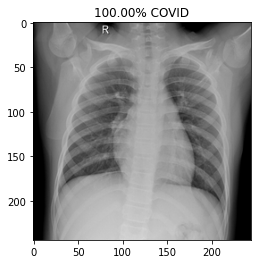

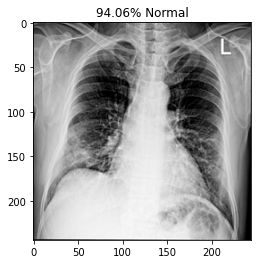

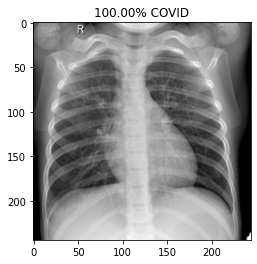

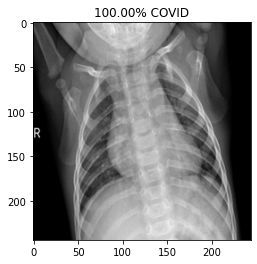

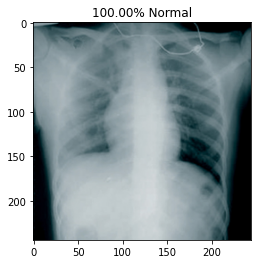

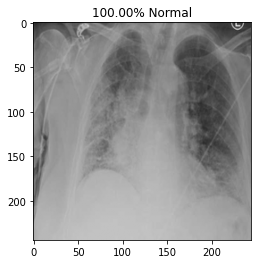

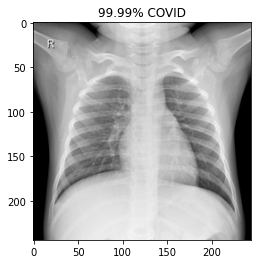

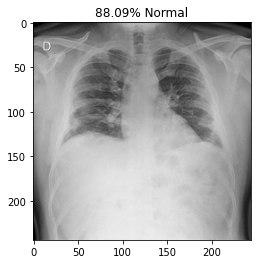

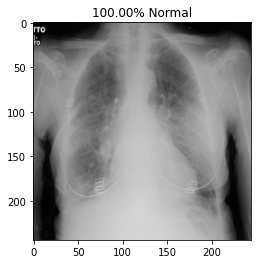

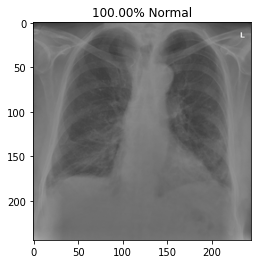

In [22]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Normal')
  plt.imshow(testX[index])
  plt.show()

In [26]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(testY, axis=1)

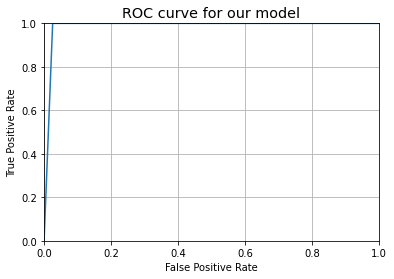

In [27]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


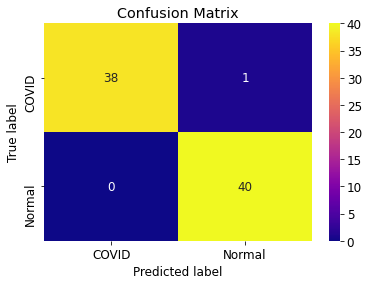

Confusion Matrix with Normalized Values


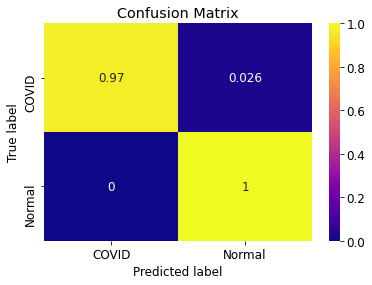

In [28]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','Normal']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('/content/drive/My Drive/deep learning projects/covid19/keras-covid-19/vgg_chest_confusion.png')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [29]:
#Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        39
           1       0.98      1.00      0.99        40

    accuracy                           0.99        79
   macro avg       0.99      0.99      0.99        79
weighted avg       0.99      0.99      0.99        79



Label = [1. 0.]
image shape:  (244, 244, 3)


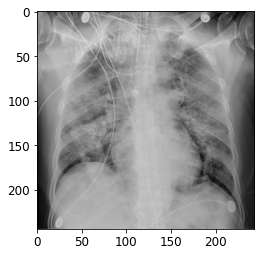

In [30]:
index=43
image=testX[index]
city_coders.display_image(testX,testY,index)

In [31]:
image=city_coders.reshape_image_for_neural_network_input(image)
y_pred=model.predict(image,verbose=1)
print("true label: ",testY[index])
print("predicted label: ",y_pred)

flatten the image
image.shape (178608, 1)
reshape the image to be similar to the input feature vector
image.shape (1, 244, 244, 3)
1/1 [==============================] - 0s 67ms/step
true label:  [1. 0.]
predicted label:  [[0.49258828 0.5074117 ]]


In [32]:
predIdxs=np.argmax(y_pred,axis=1)
print("predicted label: ",predIdxs)

predicted label:  [1]


In [33]:
model.evaluate(testX,testY,verbose=0)

[0.0433216355741024, 0.9873417615890503]

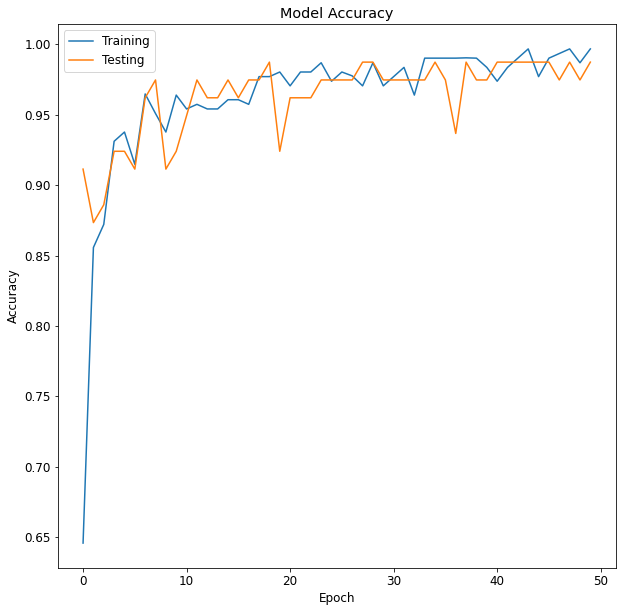

In [34]:
plt.figure(figsize=(10,10))

plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('/content/drive/My Drive/deep learning projects/covid19/keras-covid-19/vgg_chest_accuracy.png')
plt.show()

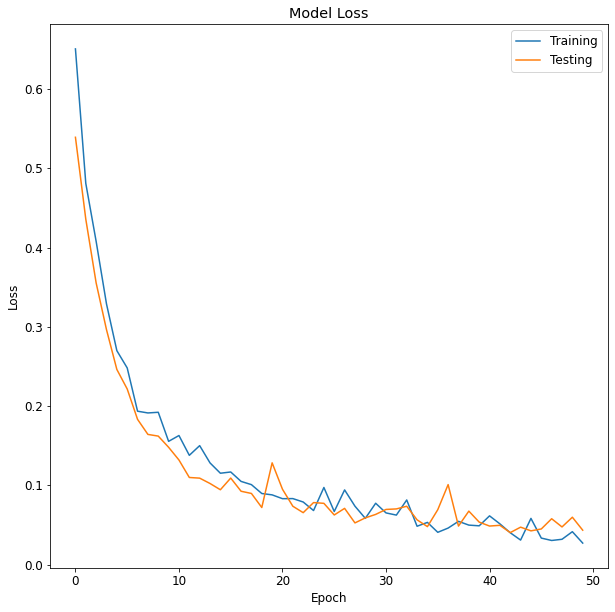

In [35]:
plt.figure(figsize=(10,10))

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('/content/drive/My Drive/deep learning projects/covid19/keras-covid-19/vgg_chest_loss.png')
plt.show()